# hypopy tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import hypo

## Joint hypocenter-velocity inversion with P-wave arrivals only

### Create first synthetic data

Define limits and build grid

In [2]:
xmin = 100.0
xmax = 201.0
ymin = 80.0
ymax = 201.0
zmin = 0.0
zmax = 71.0

dx = 10.0

g = hypo.Grid3D(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dx), np.arange(zmin, zmax, dx))

We need some receivers

In [3]:
rcv = np.array([[112., 115., 13.],
                    [151., 117., 17.],
                    [180., 115., 16.],
                    [113., 145., 11.],
                    [160., 150., 17.],
                    [185., 149., 15.],
                    [117., 184., 11.],
                    [155., 192.,  9.],
                    [188., 188., 10.],
                    [188., 186., 30.],
                    [188., 183., 60.]])
nsta = rcv.shape[0]

Let's create 15 events randomly located in the grid

In [4]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + 2.*np.random.randn(nev),       # origin time
                 130. +  5.*np.random.randn(nev),                           # x
                 160. +  5.*np.random.randn(nev),                           # y
                  35. + 10.*np.random.randn(nev))).T                        # z

For simplicity, we will use a velocity model with a small vertical gradient and mean Vp = 4000 m/s

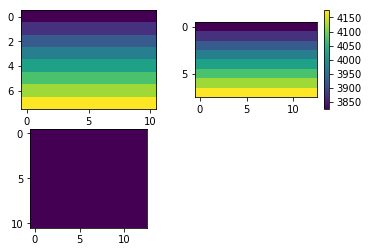

In [5]:
z = np.arange(zmin, zmax, dx) - 35.
Vz = 4000.0 + 5*z
Vp = np.kron(Vz, np.ones((g.shape[0], g.shape[1], 1)))

plt.subplot(221)
plt.imshow(np.squeeze(Vp[:,0,:].T))
plt.subplot(222)
plt.imshow(np.squeeze(Vp[0,:,:].T))
plt.colorbar()
plt.subplot(223)
plt.imshow(np.squeeze(Vp[:,:,4]))
plt.show()

Let's now compute the travel times

The raytracing routine takes 3 input variables:
- the slowness vector
- the matrix of hypocenter data (hypo)
- the matrix of receiver coordonates (rcv)

hypo and rcv must have the same number of rows, with each row corresponding to a source-receiver pair

In [6]:
slowness = Vp.flatten()

src = np.kron(src,np.ones((nsta,1)))
rcv = np.kron(np.ones((nev,1)), rcv)

tt = g.raytrace(slowness, src, rcv)

(1144,) 1144
10 12 7
